In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
from sciann import Functional, Variable, SciModel, PDE
from sciann.utils import *
import scipy.io 
import time
import random
from scipy import interpolate
from scipy import ndimage
from scipy.interpolate import griddata

from eikonalfm import factored_fast_marching as ffm
from eikonalfm import distance
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)

2024-07-10 16:19:56.969461: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-10 16:19:57.101865: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-10 16:19:57.132745: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-10 16:19:57.619748: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

---------------------- SCIANN 0.7.0.0 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.10.1 
Python Version: 3.8.16 (default, Jun 12 2023, 18:09:05) 
[GCC 11.2.0] 

Outdated SciANN installation is found (V-0.7.0.0). Get the latest version (V-0.7.0.1):  
      > pip [--user] install --upgrade sciann  


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # 禁用GPU

In [3]:
np.random.seed(123)
tf.random.set_seed(123)

In [4]:
ymin = 0.; ymax = 3; deltay = 0.025;
xmin = 0.; xmax = 4; deltax = 0.025;
zmin = 0.; zmax = 2.05; deltaz = 0.025;

mat_data = scipy.io.loadmat('./3Dvelocity/velocity_3d.mat')
vel = mat_data['v']

In [5]:
#jianboqi
# iz = 0.
# ix = np.round(np.arange(0,4.01,0.125),2); 
# iy = np.round(np.arange(0,3.01,0.125),2);
sdata = np.load('random_coordinates.npz')
sx = sdata['rx'][0]
sy = sdata['ry'][0]
sz = sdata['rz'][0]

In [6]:
z = np.arange(zmin,zmax+deltaz,deltaz)
nz = z.size

x = np.arange(xmin,xmax+deltax,deltax)
nx = x.size

y = np.arange(ymin,ymax+deltay,deltay)
ny = y.size

Z,X,Y,SX,SY,SZ= np.meshgrid(z,x,y,sx,sy,sz,indexing='ij')

X_star = [Z.reshape(-1,1), X.reshape(-1,1),Y.reshape(-1,1),SX.reshape(-1,1),SY.reshape(-1,1),SZ.reshape(-1,1)] 

In [7]:
R = np.sqrt((Z-sz)**2 + (X-sx)**2 + (Y-sy)**2); 

px1 = np.divide(X-sx, R, out=np.zeros_like(R), where=R!=0)
pz1 = np.divide(Z-sz, R, out=np.zeros_like(R), where=R!=0)
py1 = np.divide(Y-sy, R, out=np.zeros_like(R), where=R!=0)

In [9]:

K.clear_session()

hidden_layers = 8*[64]
hidden_layers2 = 8*[32]
dtype = 'float32'

xt = Variable("xt", dtype='float64')
zt = Variable("zt", dtype='float64')
yt = Variable("yt", dtype='float64')
sxt = Variable("sxt", dtype='float64')
syt = Variable("syt", dtype='float64')
szt = Variable("szt", dtype='float64')
px1t = Variable("px1t", dtype='float64')
pz1t = Variable("pz1t", dtype='float64')
py1t = Variable("py1t", dtype='float64')
Rt = Variable("Rt", dtype='float64')

taup, taus = Functional(['taup','taus'], [zt, xt, yt, szt, sxt, syt], hidden_layers, 'l-elu','sigmoid')
vp, vs = Functional(['vp','vs'], [zt, xt, yt], hidden_layers2, 'l-elu','sigmoid')

taup = taup
taus = taus
vp = vp*6.0
vs = vs*4.0

Lp = (Rt * diff(taup, xt) + taup * px1t) ** 2 + (Rt * diff(taup, zt) + taup * pz1t) ** 2 + (Rt * diff(taup, yt) + taup * py1t) ** 2 - 1.0 / vp ** 2 
Ls = (Rt * diff(taus, xt) + taus * px1t) ** 2 + (Rt * diff(taus, zt) + taus * pz1t) ** 2 + (Rt * diff(taus, yt) + taus * py1t) ** 2 - 1.0 / vs ** 2

targets = [taup*Rt, taus*Rt, Lp, Ls]

model = SciModel(
    [zt, xt, yt, szt, sxt, syt, pz1t, px1t, py1t, Rt],
    targets
)

In [10]:
pz1 = pz1.reshape(X_star[0].shape)
px1 = px1.reshape(X_star[0].shape)
py1 = py1.reshape(X_star[0].shape)
R1 = R.reshape(X_star[0].shape)

In [11]:
model.load_weights('pinntomo_over3d_new.h5')

2024-07-10 16:20:01.760432: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-07-10 16:20:01.760494: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: chao-Precision-7920-Tower
2024-07-10 16:20:01.760509: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: chao-Precision-7920-Tower
2024-07-10 16:20:01.760683: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.182.3
2024-07-10 16:20:01.760722: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.182.3
2024-07-10 16:20:01.760733: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.182.3
2024-07-10 16:20:01.761318: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to u

In [13]:
epoch_num = 200
test_data = [X_star[0],X_star[1],X_star[2],X_star[3],X_star[4],X_star[5],pz1,px1,py1,R1]
vp_pred = vp.eval(model, test_data)
vp_pred = vp_pred.reshape(Z.shape)

vs_pred = vs.eval(model, test_data)
vs_pred = vs_pred.reshape(Z.shape)

# np.save('./over3d_pinntomo_vppred_random_new%d.npy'%(epoch_num),vp_pred)
# np.save('./over3d_pinntomo_vspred_random_new%d.npy'%(epoch_num),vs_pred)

taup_pred = taup.eval(model, test_data)
Tp_pred = taup_pred*R1
taup_pred = taup_pred.reshape(Z.shape)
Tp_pred = Tp_pred.reshape(Z.shape)
# np.save('./over_pinntomo_taup_pred_random_new%d.npy'%(epoch_num),taup_pred)
# np.save('./over_pinntomo_Tppred_random_new%d.npy'%(epoch_num),Tp_pred)

taus_pred = taus.eval(model, test_data)
Ts_pred = taus_pred*R1
taus_pred = taus_pred.reshape(Z.shape)
Ts_pred = Ts_pred.reshape(Z.shape)
# np.save('./over_pinntomo_taus_pred_random_new%d.npy'%(epoch_num),taus_pred)
# np.save('./over_pinntomo_Tppred_random_new%d.npy'%(epoch_num),Tp_pred)

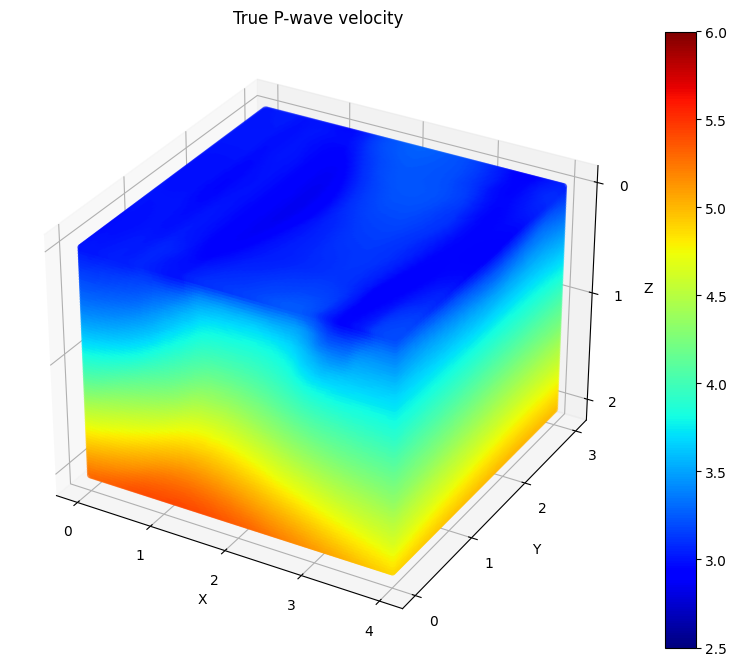

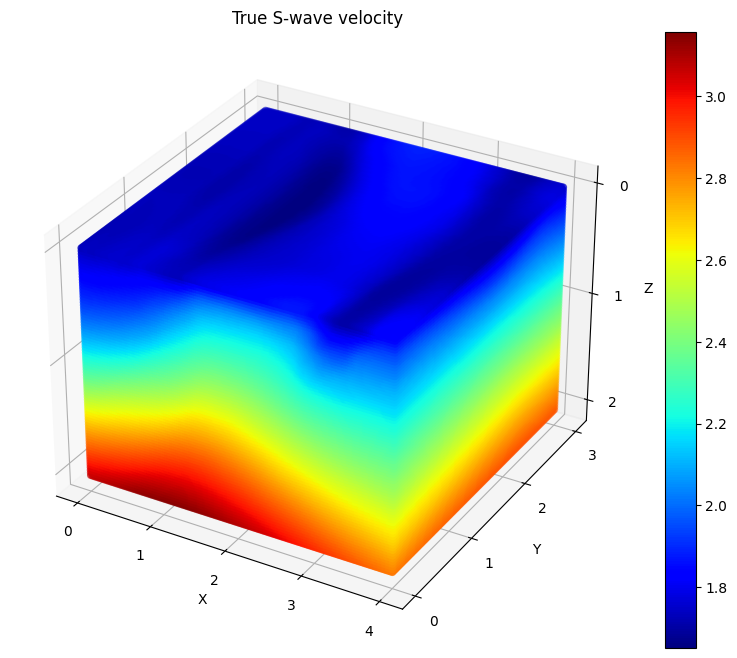

In [14]:

fig = plt.figure(figsize=(10, 8))

ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(X, Y, Z, c=(vp_pred).flatten(), cmap='jet')

# 添加颜色条
cbar = plt.colorbar(sc)
cbar.mappable.set_clim(2.5,6)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.invert_zaxis()
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(1))
ax.zaxis.set_major_locator(plt.MultipleLocator(1))

ax.set_title('Predicted P-wave velocity')

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(X, Y, Z, c=((vs_pred)).flatten(), cmap='jet')

# 添加颜色条
cbar = plt.colorbar(sc)
# cbar.mappable.set_clim(2.5,6)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.invert_zaxis()
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(1))
ax.zaxis.set_major_locator(plt.MultipleLocator(1))

ax.set_title('Predicted S-wave velocity')

plt.show()

In [18]:
vp_pred = (vp_pred.reshape(nz,nx,ny))
scipy.io.savemat('over3d_vp_pred_new_sparse.mat',{'vp_pred':vp_pred})

vs_pred = (vs_pred.reshape(nz,nx,ny))
scipy.io.savemat('over3d_vs_pred_new_sparse.mat',{'vs_pred':vs_pred})

In [16]:
# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')

# sc = ax.scatter(X, Y, Z, c=(np.abs(tau_pred)).flatten(), cmap='jet')

# # 添加颜色条
# cbar = plt.colorbar(sc)


# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')


# ax.invert_zaxis()

# ax.set_title('T-ERROR')

# plt.show()

In [17]:

# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')

# sc = ax.scatter(X, Y, Z, c=(np.abs(T_pred[:,:,:,0] - T_data)).flatten(), cmap='jet')

# # 添加颜色条
# cbar = plt.colorbar(sc)


# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')


# ax.invert_zaxis()

# ax.set_title('T-ERROR')

# plt.show()